In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]

abc (generic function with 1 method)

In [3]:
# Circuit
Z0 = 13.2
Rs = 3000 # Ω
RL = 2Z0  # Ω
V0 = 5000 # V

# Parameters
Δt = 0.05e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
nothing

In [4]:
a, b = 2.00, 0.08
n, m = 100, 4
lx = a / n
ly = b / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [5]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_LOAD = 4
DOF_SG   = 5

function dof_type(n, m)
    global NUM_EDGES
    N = NUM_EDGES
    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]
    start, stop = extrema(h[3])
    h[3] = start:stop - 5
    
    dof_flag = zeros(Int64, N)
    
    dof_flag[(h[1])] .= DOF_PEC # BOTTOM
    dof_flag[(h[3])] .= DOF_PEC # MIDDLE
    dof_flag[(h[5])] .= DOF_PEC # TOP
    
    dof_flag[first(v[1])] = DOF_SRC
    dof_flag[first(v[2])] = DOF_SRC
    
    dof_flag[first(v[3])] = DOF_SG
    dof_flag[first(v[4])] = DOF_SG
    
    dof_flag[ last(v[1])] = DOF_LOAD
    dof_flag[ last(v[2])] = DOF_LOAD
    dof_flag[ last(v[3])] = DOF_LOAD
    dof_flag[ last(v[4])] = DOF_LOAD
    
    return dof_flag
end

dof_type (generic function with 1 method)

In [6]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

In [7]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

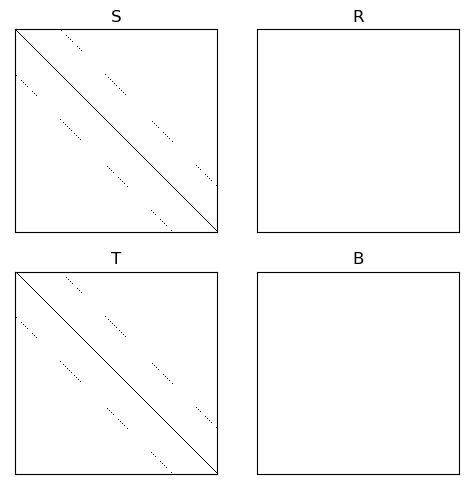

In [8]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [9]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [10]:
mm = 1e-3 # m
atm = 101_325.0 # Pa
gasdensity(p) = 1.2p/1atm # at 25 degrees C.
electricfield(V, d) = V/d

# channel radius
# ρ in [kg/m3], i in [A], t in [s], result in [m]
braginskii(ρ, i, t) = 9.3e-4 * (1e-3*i)^(1/3) *
                               (1e+6*t)^(1/2) *
                               (1e-3*ρ)^(1/6)
# breakdown delay
# E in [V/m], ρ in [kg/m3], result in [s]
thmartin(E, ρ) = (987e2/1e-3ρ) * (1e-5E/1e-3ρ)^(-3.44)

# breakdown voltage
# p in [Pa], d in [m], result in [V]
bruce(p, d) = 24550 *     (1e2d * p / 1atm) + 
               6660 * sqrt(1e2d * p / 1atm)

# wire inductance
# r in [m], d in [m], result in [H] 
grover(r, d) = 200e-9d * (log(200d / r) - .75)

# arc resistance
# r in [m], d in [m], i in [A], result in [Ω]
vlastos(r, d, ∫i²) = 876d * r^(2/5) / ∫i²^(3/5)
nothing

In [11]:
using StaticArrays
using ACME

nonlinear_eq = @inline function(q, params)
    v, i, Φ, u = q
    if params["channel_on"] == false
        j = @SVector [(v - u), (i)]
        J = @SMatrix [(1) (0.) (.0) (-1);
                      (0) (1.) (.0) (.0)] 
    else
        if i ≈ 0.0 i = 1e-12 end
        i = float(i) + ϵi
        ch_rad = braginskii(gasdensity(params["pressure"]), abs(i), params["t_arc"])
        R  = vlastos(ch_rad, params["distance"], params["∫i²"] + (i^2) * params["Δt"])
        L  = 3.0grover(ch_rad, params["distance"])
        Ri = R*i
        Li = L*i
        params["ch_rad"] = ch_rad.v
        params["R"] = R.v
        params["L"] = L.v
        j = @SVector [(Ri.v - u), (Li.v - Φ)]
        J = @SMatrix [(0) (Ri.di) (.0) (-1);
                      (0) (Li.di) (-1) (.0)] 
    end
    return (j, J)
    end

afternewton = @inline function(q, params)
    v, i, Φ, u = q
    i = float(i)
    if params["channel_on"]
        if i > params["i_min"]
            params["t_arc"] += params["Δt"]
            params["∫i²"] += i^2 * params["Δt"]
        else
            params["channel_on"] = false
            params["∫i²"] = 0.0
            params["t_arc"] = 0.0
            params["R"] = NaN
            params["L"] = NaN
            params["ch_rad"] = NaN
        end
    elseif v > params["v_break"]
        t_delay = thmartin(electricfield(v,params["distance"]), gasdensity(params["pressure"]))
        params["t_over"] += params["Δt"]
        if params["t_over"] > t_delay
            params["channel_on"] = true
            params["∫i²"] = i^2 * params["Δt"]
            params["t_arc"] = params["Δt"]
            params["t_over"] = 0.0
        end
    end
end

arcchannel() =
  ACME.Element(mv=[1;1;0;0;0], mi=[0;0;1;0;0], mx=[0 -1;0 0;0 0;1 0;0 1], mxd=[-1 0;0 0;0 0;0 0;0 0],
        mq=[0 0 0 0;-1 0 0 0;0 -1 0 0; 0 0 -1 0; 0 0 0 -1], ports=[:1 => :2],
        nonlinear_eq = nonlinear_eq)

include("automatic-differentiation.jl")
include("circuit-model.jl")

states (generic function with 1 method)

In [12]:
params = Dict{String, Any}(
    "R" => NaN,
    "L" => NaN,
    "ch_rad" => NaN,
    "v_break" => bruce(1atm, 1mm),
    "pressure" => 1atm,
    "distance" => 1mm,
    "channel_on" => false,
    "i_min" => 5e-5,
    "Δt" => Δt,
    "∫i²" => 0.0,
    "t_arc" => 0.0,
    "t_over" => 0.0
)

sparkgap = let
    cir = @circuit begin
        i = currentprobe()
        v = voltagesource()
        ⚡ = arcchannel()
    end

    connect!(cir, (:v, +), (:i, +))
    connect!(cir, (:i, -), (:⚡, 1))
    connect!(cir, (:v, -), (:⚡, 2), :gnd)

    A, B, C, Di, Ei, Fi, Dv, Ev, Fv, Dq, Eq, Fq = matrices(cir, Δt, 1)
    x̄, y, ū, q̄, z = states(B, C, Di, Dq, T=Dual{Float64})
    DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq,
        x̄, y, ū, q̄, z, params)
end
nothing

In [13]:
voltage = let
    cir = @circuit begin
        i = currentprobe()
        u = voltagesource()
        v = voltagesource()
        l = inductor(1e-12)
        r = resistor(Rs)
    end

    connect!(cir, (:u, +), (:v, -))
    connect!(cir, (:v, +), (:l, 1))
    connect!(cir, (:l, 2), (:r, 1))
    connect!(cir, (:r, 2), (:i, +))
    connect!(cir, (:i, -), :gnd)
    connect!(cir, (:u, -), :gnd)


    A, B, C, Di, Ei, Fi, Dv, Ev, Fv, Dq, Eq, Fq = matrices(cir, Δt, 1)
    x̄, y, ū, q̄, z = states(B, C, Di, Dq, T=Dual{Float64})
    DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq,
        x̄, y, ū, q̄, z, Dict{String, Any}())
end
nothing

In [14]:
antenna = let
    cir = @circuit begin
        i = currentprobe()
        u = voltagesource()
        r = resistor(2.344e+3)
        l = inductor(786.9e-9)
        c = capacitor(5.19e-12)
        rsh = resistor(1e2)
        lsh = inductor(800e-6)
    end

    connect!(cir, (:lsh, 2), (:rsh, 1))
    connect!(cir, (:u, +), (:lsh, 1))
    connect!(cir, (:i, +), (:rsh, 2))
    connect!(cir, (:u, +), (:c, 1))
    connect!(cir, (:c, 2), (:l, 1), (:r, 1))
    connect!(cir, (:i, +), (:l, 2), (:r, 2))
    connect!(cir, (:i, -), (:u, -), :gnd)

    A, B, C, Di, Ei, Fi, Dv, Ev, Fv, Dq, Eq, Fq = matrices(cir, Δt, 1)
    x̄, y, ū, q̄, z = states(B, C, Di, Dq, T=Dual{Float64})
    DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq,
        x̄, y, ū, q̄, z, Dict{String, Any}())
end
nothing

In [15]:
sigmoid(x) = 1.0 / (1.0 + exp(-10x))
Rsp(τ) = sigmoid(τ - 1.0)

function assemble_circuit!(i, didv, v, t)
    vL = sum(v[dof[Γ .== DOF_LOAD]])
    vSG = sum(v[dof[Γ .== DOF_SG]])
    vSRC = sum(v[dof[Γ .== DOF_SRC]])
    
    #x = first(step!(copy(antenna), vL + ϵv))
    y = first(step!(copy(sparkgap), vSG + ϵv, nonlinear_eq))
    z = first(step!(copy(voltage),[vSRC + ϵv; V0]))
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == DOF_SG # realistic spark-gap (Pouncey&Lehr)
            i[jj] = (y.v) * (b / ly)
            didv[jj, jj] =  (y.dv) * (b / ly)
        end
        
        if Γ[ii] == DOF_SG # time-triggered primitive, spark-gap
            #R = 1e15 - 1e15Rsp(1e9t - 894) + 1e15Rsp(1e9t - 913) + 0.1
            #i[jj] = v[jj] * 1.0 / R * (b / ly)
            #didv[jj, jj] =  1.0 / R * (b / ly)
        end

        if Γ[ii] == DOF_SRC
            i[jj] = (z.v) * (b / ly)
            didv[jj, jj] = (z.dv) * (b / ly)
        end

        if Γ[ii] == DOF_LOAD
            #i[jj] = (x.v) * (b / ly)
            #didv[jj, jj] = (x.dv) * (b / ly)
            i[jj] = v[jj] * 1.0 / RL * (b / ly)
            didv[jj, jj] =  1.0 / RL * (b / ly)
        end
    end
end

assemble_circuit! (generic function with 1 method)

In [16]:
using JLD2


function calculate_current(h, bnd)
    i = 0.0
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == bnd
            i += h[jj]
        end
    end
    return i
end

function calculate_voltage(e, bnd)
    v = 0.0
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == bnd
            v += e[jj]
        end
    end
    return v
end

x = 0.010:0.050:0.51
y = 0.005:0.012:0.07
xx, yy = meshgrid(x, y);

nt  = 40_000
t   = 0.00
e   = zeros(NUM_EDGES)
h   = zeros(NUM_EDGES)

ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
hp  = zeros(NUM_EDGES)
hpp = zeros(NUM_EDGES)

dhde = spzeros(NUM_EDGES, NUM_EDGES)
v = Dict{Int8, Vector{Float64}}(DOF_SG => zeros(nt), DOF_SRC => zeros(nt), DOF_LOAD => zeros(nt))
i = Dict{Int8, Vector{Float64}}(DOF_SG => zeros(nt), DOF_SRC => zeros(nt), DOF_LOAD => zeros(nt))
r = [NaN for i=1:nt]
l = [NaN for i=1:nt]
⚡ = falses(nt)
nothing

In [17]:
using ProgressMeter; 
ProgressMeter.ijulia_behavior(:clear)
progress = Progress(nt)

N = 0
Δe = similar(e)
Fi = zeros(NUM_EDGES)
Ji = spzeros(NUM_EDGES, NUM_EDGES)
for it=1:nt
    bi = (0.50Δt^2 * S - 2T) * ep + (0.25Δt^2 * S +  T - 0.5Δt * B - 0.5Δt * R) * epp
    
    fill!(Δe, Inf)
    while norm(Δe) > 1e-12 && N < 10
        assemble_circuit!(h, dhde, e, t)
        Fi .= A*e + 0.5Δt * ly^2 * μ0 * h - 0.5Δt * ly^2 * μ0 * hpp + bi
        Ji .= A   + 0.5Δt * ly^2 * μ0 * dhde
        Δe .= Ji\Fi
        e .-= Δe
        N += 1
    end
    
    assemble_circuit!(h, dhde, e, t)
    #step!(antenna, sum(e[dof[Γ .== DOF_LOAD]]))
    step!(sparkgap, sum(e[dof[Γ .== DOF_SG]]), nonlinear_eq)
    step!(voltage, [sum(e[dof[Γ .== DOF_SRC]]); V0])
    afternewton(sparkgap.q̄, sparkgap.params)
    N = 0
    
    epp .= ep
    ep  .= e

    hpp .= hp
    hp  .= h
    
    r[it] = params["R"]
    l[it] = params["L"]
    ⚡[it] = params["channel_on"]
    for boundary in [DOF_LOAD, DOF_SG, DOF_SRC]
        v[boundary][it] = calculate_voltage(e, boundary)
        i[boundary][it] = calculate_current(h, boundary)
    end
    
    t  += Δt
    
    update!(progress, it; showvalues=[
            (:t, 1e9t),
            (:channel, ⚡[it]),
            (:nonlinear, norm(Δe)),
            (:sparkgap, v[DOF_SG][it]),
            (:source, v[DOF_SRC][it]),
            (:load, v[DOF_LOAD][it])
            ])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:04:02
  t:          1999.999999998321
  channel:    false
  nonlinear:  6.386369715853792e-13
  sparkgap:   457.0252113124168
  source:     -415.08654264129854
  load:       45.63679180170722


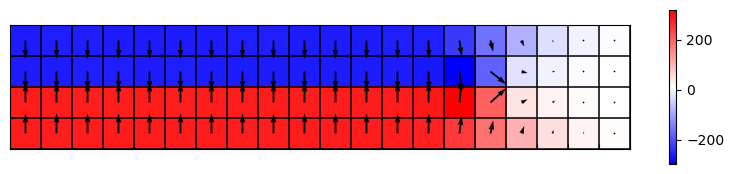

In [43]:
using PyPlot
x = (1:n) .* (a/n) .- 0.5(a/n)
y = (1:m) .* (b/m) .- 0.5(b/m)
E = evaluate(WhitneyRectangleElement(), e, dof, x, y,
    length(x), length(y), a/n, b/m, el2ed, el2edd)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx, yy = meshgrid(x, y);

figure(figsize=(10, 2))
imshow(E[:,:,2]', cmap="bwr", interpolation="none"); colorbar()
quiver(E[:,:,1]',E[:,:,2]')
xticks(0.5:n, labels=[])
yticks(0.5:m, labels=[])
xlim((79.5, 99.5))
gca().tick_params(direction="in")
gca().grid(color="k", linewidth=1.1)

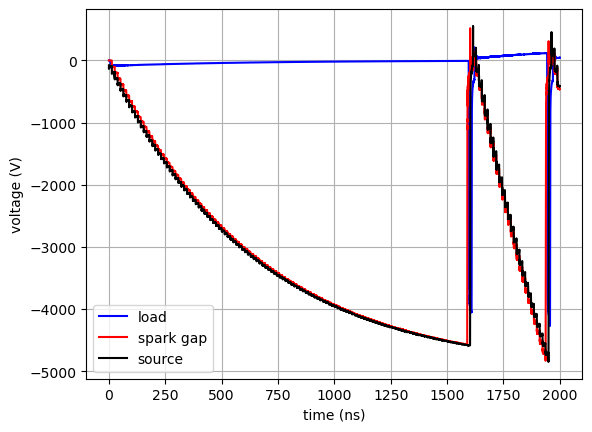

PyObject <matplotlib.legend.Legend object at 0x7fae4e482e20>

In [23]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, v[DOF_LOAD],"b-")
plot(ts,-v[DOF_SG],  "r-")
plot(ts, v[DOF_SRC], "k-")
#xlim([1580, 1620])
#ylim([-8800,+5900])
ylabel("voltage (V)")
legend(["load", "spark gap", "source"])

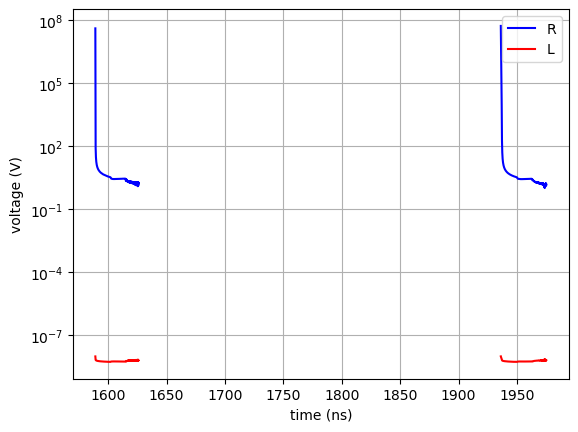

PyObject <matplotlib.legend.Legend object at 0x7fae08057250>

In [20]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
semilogy(ts, r, "b-")
semilogy(ts, l, "r-")
#xlim([880, 1000])
ylabel("voltage (V)")
legend(["R", "L"])

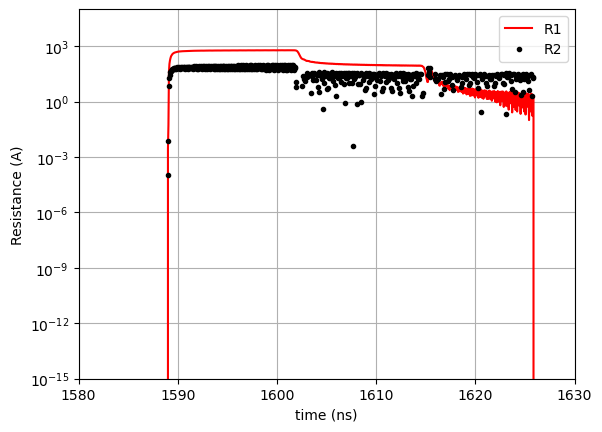

PyObject <matplotlib.legend.Legend object at 0x7fae4d7066d0>

In [24]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
#plot(ts, i[DOF_LOAD],"b-")
#semilogy(ts, v[DOF_SG] ./ i[DOF_SG],  "r-")
#semilogy(ts, 0.125r,  "k-")
semilogy(ts, i[DOF_SG], "r-")
semilogy(ts, v[DOF_SG]./r,  "k.")
#plot(ts, i[DOF_SRC], "k-")
xlim([1580, 1630])
ylim((1e-15,1e5))
#ylim((50, 1000))
#ylim((0.1,10))
ylabel("Resistance (A)")
legend(["R1", "R2"])

In [22]:
params["∫i²"]
#cumsum(i[DOF_SG] .^ 2 .* Δt)

0.0